## Atuação de redes neurais na base de dados do ENEM.

##### Alunos:

-   Gabriel Fonseca (2111066)
-   Yasmim Santos (2116925)
-   Alejandro Elias (2111189)
-   Pedro Lucas (2111131)

Base de dados escolhida - Exame Nacional do Ensino Médio (Enem): https://basedosdados.org/dataset/3e9c8804-c31c-4f48-9a45-d67f1c21a859


In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from yellowbrick.cluster import KElbowVisualizer

In [101]:
df_enem = pd.read_csv(
    f"../data/out/enem-dados-tratados.csv",
    dtype={
        "id_inscricao": np.int64,
        "ensino": int,
        "nota_ciencias_natureza": float,
        "nota_ciencias_humanas": float,
        "nota_linguagens_codigos": float,
        "nota_matematica": float,
        "nota_redacao": float,
        "q_formacao_pai": str,
        "q_formacao_mae": str,
        "q_renda_familia": str,
    },
)

df_enem["q_renda_familia_classe"] = df_enem["q_renda_familia"].map(
    {
        "A": "nenhuma_renda",
        "B": "muito_baixa_renda",
        "C": "muito_baixa_renda",
        "D": "muito_baixa_renda",
        "E": "muito_baixa_renda",
        "F": "baixa_renda",
        "G": "baixa_renda",
        "H": "baixa_renda",
        "I": "baixa_renda",
        "J": "media_renda",
        "K": "media_renda",
        "L": "media_renda",
        "M": "media_renda",
        "N": "alta_renda",
        "O": "alta_renda",
        "P": "alta_renda",
        "Q": "alta_renda",
    }
)

colunas_red = [
    "nota_ciencias_natureza",
    "nota_ciencias_humanas",
    "nota_linguagens_codigos",
    "nota_matematica",
]

colunas_red_norm = [
    "cn_norm",
    "ch_norm",
    "lc_norm",
    "ma_norm",
]

mm_scaler = MinMaxScaler()
df_enem[colunas_red_norm] = mm_scaler.fit_transform(df_enem[colunas_red])

for col, col_norm in zip(colunas_red, colunas_red_norm):
    df_enem = df_enem[df_enem[col] != 0.0]
    df_enem = df_enem[df_enem[col_norm] != 0.0]

# tirando as colunas do dataframe
df_enem = df_enem.drop(
    columns=[
        "id_inscricao",
        "ensino",
        "nota_redacao",
        "q_formacao_pai",
        "q_formacao_mae",
        "q_renda_familia",
        "ano",
    ]
)

df_enem.dropna(inplace=True)
df_enem.reset_index(drop=True, inplace=True)
df_enem

,nota_ciencias_natureza,nota_ciencias_humanas,nota_linguagens_codigos,nota_matematica,q_renda_familia_classe,cn_norm,ch_norm,lc_norm,ma_norm
0,366.8,436.9,374.2,331.4,muito_baixa_renda,0.420980,0.506492,0.465539,0.333736
1,512.0,636.9,552.0,549.2,muito_baixa_renda,0.587628,0.738349,0.686738,0.553072
2,470.8,519.3,465.2,350.8,muito_baixa_renda,0.540342,0.602017,0.578751,0.353273
3,492.6,641.2,553.2,649.5,nenhuma_renda,0.565362,0.743334,0.688231,0.654079
4,473.3,533.4,443.3,447.4,nenhuma_renda,0.543211,0.618363,0.551505,0.450554
...,...,...,...,...,...,...,...,...,...
355501,450.6,403.1,443.3,479.8,muito_baixa_renda,0.517158,0.467308,0.551505,0.483182
355502,416.5,427.3,484.6,376.2,nenhuma_renda,0.478021,0.495363,0.602886,0.378852
355503,462.1,421.7,432.1,530.9,muito_baixa_renda,0.530357,0.488871,0.537572,0.534642
355504,519.1,570.4,537.3,388.7,muito_baixa_renda,0.595776,0.661257,0.668450,0.391440


In [102]:
df_renda = df_enem[["q_renda_familia_classe"]].reset_index(drop=True)

X = df_enem[colunas_red_norm].copy()
X.dropna(inplace=True)
X.reset_index(drop=True, inplace=True)

pca = PCA(n_components=2).fit_transform(X)
df_new = pd.DataFrame(data=pca, columns=["pc1", "pc2"])
df_new = pd.concat([df_new, df_renda], axis=1)
df_new.columns = ["pc1", "pc2", "labels"]
df_new.dropna(inplace=True)

df_new

,pc1,pc2,labels
0,-0.215173,-0.054754,muito_baixa_renda
1,0.206789,-0.067334,muito_baixa_renda
2,-0.045283,-0.116139,muito_baixa_renda
3,0.253556,0.003884,nenhuma_renda
4,0.002126,-0.038863,nenhuma_renda
...,...,...,...
355501,-0.071931,0.057554,muito_baixa_renda
355502,-0.103385,-0.061285,nenhuma_renda
355503,-0.034667,0.093356,muito_baixa_renda
355504,0.075411,-0.144363,muito_baixa_renda


Text(0, 0.5, 'PC2')

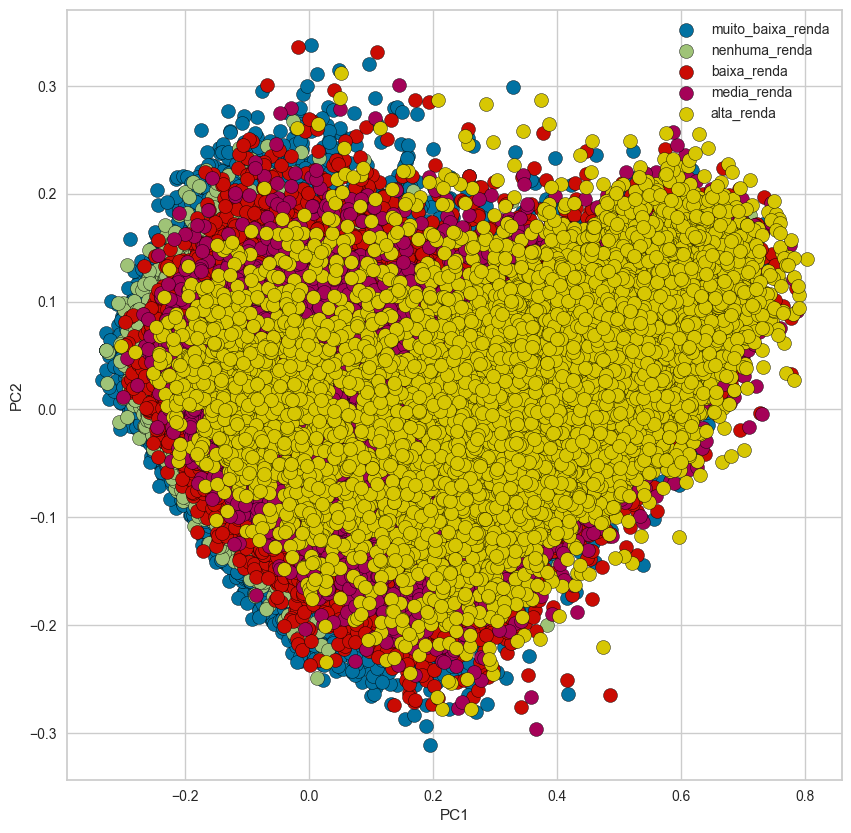

In [103]:
plt.figure(figsize=(10, 10))

for lbl in df_new["labels"].unique():
    c = df_new[df_new["labels"] == lbl]
    plt.scatter(c["pc1"], c["pc2"], s=100, edgecolors="black")

plt.legend(df_new["labels"].unique())
plt.xlabel("PC1")
plt.ylabel("PC2")

In [104]:
pca2d = PCA(n_components=2)
components = pca2d.fit_transform(X)

total_var = pca2d.explained_variance_ratio_.sum() * 100

df_new_2d = pd.DataFrame(components, columns=["pc1", "pc2"])
df_new_2d = pd.concat([df_new_2d, df_renda], axis=1)
df_new_2d

,pc1,pc2,q_renda_familia_classe
0,-0.215173,-0.054754,muito_baixa_renda
1,0.206789,-0.067334,muito_baixa_renda
2,-0.045283,-0.116139,muito_baixa_renda
3,0.253556,0.003884,nenhuma_renda
4,0.002126,-0.038863,nenhuma_renda
...,...,...,...
355501,-0.071931,0.057554,muito_baixa_renda
355502,-0.103385,-0.061285,nenhuma_renda
355503,-0.034667,0.093356,muito_baixa_renda
355504,0.075411,-0.144363,muito_baixa_renda


In [105]:
pca = PCA()
pca.fit(df_enem[colunas_red])
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"},
)

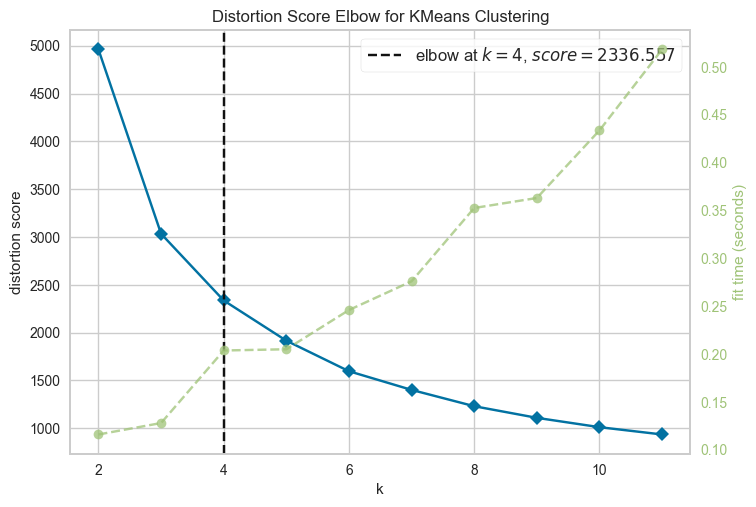

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [106]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 12))

X_kmeans = df_new_2d[["pc1", "pc2"]].to_numpy()

visualizer.fit(X_kmeans)

k = visualizer.elbow_value_

visualizer.show()

In [107]:
kmeans = KMeans(n_clusters=k)
kmeans.fit(X_kmeans)

sil_score = silhouette_score(
    X_kmeans,
    kmeans.labels_,
    metric="euclidean",
    sample_size=50000,
)

print(f"Silhouette Score: {sil_score:.2%}")

Silhouette Score: 37.66%


In [108]:
map_renda_para_ord = {
    "nenhuma_renda": 0,
    "muito_baixa_renda": 1,
    "baixa_renda": 2,
    "media_renda": 3,
    "alta_renda": 4,
}

map_ord_para_renda = {
    0: "nenhuma_renda",
    1: "muito_baixa_renda",
    2: "baixa_renda",
    3: "media_renda",
    4: "alta_renda",
}

df_new_2d["q_renda_familia_classe_ord"] = df_enem["q_renda_familia_classe"].map(
    map_renda_para_ord
)
df_new_2d["q_renda_familia_classe_predito"] = kmeans.labels_
df_new_2d["q_renda_familia_classe_predito_label"] = df_new_2d[
    "q_renda_familia_classe_predito"
].map(map_ord_para_renda)

df_new_2d

,pc1,pc2,q_renda_familia_classe,q_renda_familia_classe_ord,q_renda_familia_classe_predito,q_renda_familia_classe_predito_label
0,-0.215173,-0.054754,muito_baixa_renda,1,0,nenhuma_renda
1,0.206789,-0.067334,muito_baixa_renda,1,1,muito_baixa_renda
2,-0.045283,-0.116139,muito_baixa_renda,1,3,media_renda
3,0.253556,0.003884,nenhuma_renda,0,1,muito_baixa_renda
4,0.002126,-0.038863,nenhuma_renda,0,3,media_renda
...,...,...,...,...,...,...
355501,-0.071931,0.057554,muito_baixa_renda,1,0,nenhuma_renda
355502,-0.103385,-0.061285,nenhuma_renda,0,3,media_renda
355503,-0.034667,0.093356,muito_baixa_renda,1,3,media_renda
355504,0.075411,-0.144363,muito_baixa_renda,1,1,muito_baixa_renda


In [109]:
X_mlp = df_new_2d[["pc1", "pc2"]].to_numpy()
y_mlp = df_new_2d["q_renda_familia_classe_ord"].to_numpy()

X_train_mlp, X_test_mlp, y_train_mlp, y_test_mlp = train_test_split(
    X_mlp, y_mlp, test_size=0.2, random_state=42
)

mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000)
mlp.fit(X_train_mlp, y_train_mlp)

MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000)

In [110]:
predictions_mlp = mlp.predict(X_test_mlp)
accuracy_mlp = accuracy_score(y_test_mlp, predictions_mlp)
print(f'Accuracy (MLP): {accuracy_mlp}')

Accuracy (MLP): 0.7501476751708813
